<a href="https://colab.research.google.com/github/m-mehabadi/grad-maker/blob/main/notebooks/Testing_GradientMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/dual-ascent.pdf

https://web.stanford.edu/class/ee364b/lectures/primal_dual_subgrad_slides.pdf

https://www.cvxpy.org/examples/basic/quadratic_program.html

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [34]:
def gmaker(grads, epochs = 100, method="simple", start="zero", verbose=1):
    lr = 0.01
    n, d = grads.shape
    w = np.random.randn(d) if start=="normal" else np.zeros(d)
    max_count = 0
    # max_w = None
    for e in range(epochs):
        ge = grads[e%n]
        w_new = w + lr * (1. - (ge@w > 0)) * ge
        # w = w_new/np.linalg.norm(w_new)
        w = w_new if method=="simple" else w_new/np.linalg.norm(w_new)
        # pos_count = np.sum(grads@w>0)
        # max_count = pos_count if pos_count >= max_count else max_count
        # max_w = w if pos_count >= max_count else max_w
        # if pos_count >= max_count:
        #     max_count = pos_count
    
    pos_count = np.sum(grads@w>0)
    total_count = n

    if verbose > 0:
        # print(f"For {epochs} epochs: {pos_count} out of {n}, and maximum of {max_count}")
        print(f"For {epochs} epochs: {pos_count} out of {n}")
    
    return w, (pos_count, max_count, total_count)

def gmaker_torch(grads, epochs = 100, method="simple", start="zero", verbose=1, device=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device
    lr = 0.01
    n, d = grads.size()
    w = torch.randn(d) if start=="normal" else torch.zeros(d)
    w = w.to(device)
    max_count = 0
    for e in range(epochs):
        ge = grads[e%n]
        w_new = w + lr * (1. - (ge@w > 0).int()) * ge
        w = w_new if method=="simple" else w_new/torch.norm(w_new)
        # w = w_new/np.linalg.norm(w_new)
        # max_count = pos_count if pos_count >= max_count else max_count
        # if pos_count >= max_count:
        #     max_count = pos_count
    
    pos_count = torch.sum(grads@w > 0)
    total_count = n

    if verbose > 0:
        # print(f"For {epochs} epochs: {pos_count} out of {n}, and maximum of {max_count}")
        print(f"For {epochs} epochs: {pos_count} out of {n}")
    
    return w, (pos_count, max_count, total_count)

### Testcases

Now let's write some test cases to make sure everything is working correctly


### Pytorch test

#### CPU test

In [14]:
size = (2000, 7840)
grads = torch.randn(size).to('cpu')
gmaker_torch(grads, device='cpu', epochs=10000)

For 10000 epochs: 1997 out of 2000


(tensor([-0.2214,  0.0871,  0.2956,  ...,  0.2232,  0.5875, -0.2027]),
 (tensor(1997), 0, 2000))

#### GPU test

In [4]:
size = (2000, 7840)
grads = torch.randn(size).to('cuda')
gmaker_torch(grads)

For 100 epochs: 1028 out of 2000, and maximum of 1062


(tensor([-0.1040, -0.0144, -0.0493,  ..., -0.0979, -0.0286, -0.1028],
        device='cuda:0'),
 (tensor(1028, device='cuda:0'), tensor(1062, device='cuda:0'), 2000))

### Testcase 1:

In [35]:
shape = (2000, 7840)
grads = 1e-10*(1000*(np.random.randn(*shape)+1))*np.random.randn(*shape)

For 1 epochs: 992 out of 2000
For 10 epochs: 989 out of 2000
For 100 epochs: 1040 out of 2000
For 1000 epochs: 1363 out of 2000
For 10000 epochs: 1995 out of 2000
For 100000 epochs: 2000 out of 2000


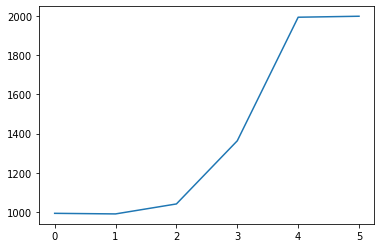

In [36]:
epochs_power = 6
counts = []
for i in [10**j for j in range(epochs_power)]:
    g, (pos_count, _, _) = gmaker(grads, epochs=i, start="zero")
    counts.append(pos_count)
plt.plot(list(range(epochs_power)), counts)

### Testcase 2:
Let's see how this algorithm works on vectors in lower dimensional spaces from the high dimensional space ($R^d$) they belong to.

In [42]:
def plotter(x, poses, iden=1):
    plt.figure(figsize=(16, 10))
    if iden>0: plt.plot(x, x, label="identity (for comparison)")
    plt.plot(x, poses, label="num of positives found")
    plt.legend()
    plt.show()

#### One dimensional subspace:

In [23]:
n, d = 100, 2000

# u1 = np.random.randn(d)
u1 = np.zeros(d)
u2 = np.random.randn(d)

point = lambda t: t*(u2-u1) + u1

vecs = []
for i in range(n):
    vecs.append(point(np.random.randn()))
grads = np.stack(vecs, axis=0)
print(grads.shape)

(100, 2000)


In [24]:
g, _ = gmaker(grads, epochs=10000)
print(g.shape)
print(grads@g>=0)

For 10000 epochs: 48 out of 100
(2000,)
[False  True  True False False False  True False  True False False  True
 False False False  True False  True False False False  True  True  True
  True False  True  True False  True  True  True False False False  True
 False False  True False  True False  True  True False  True False  True
  True False  True False False  True  True  True False False  True False
  True False False  True False False False False  True  True False  True
  True False False False  True  True  True  True  True  True False  True
 False False  True  True False False False  True False False False False
  True  True False  True]


### Linear subspace with arbitrary dimension $d_{sub}<=d$

In [26]:
n, d = 100, 2000

class PointGenerator():
    def __init__(self, d_sub, d, U=None):
        ### U is the set of vectors as basis of the subspace.
        ### If tuple is passed, then d_sub number of random vectors in R^d
        ### will be generated using `np.random.randn` function.

        self.d_sub = d_sub
        self.d = d
        self.U = U if U is not None else np.random.randn(d_sub, d)
    
    def point(self, w=None):
        w = w if w is not None else np.random.randn(self.d_sub)
        return self.U.T@w
    
    def pt(self, w=None):
        return self.point(w)

In [27]:
pgen = PointGenerator(1, d)

print(pgen.point(np.array([0])))
print(pgen.point())

[0. 0. 0. ... 0. 0. 0.]
[-0.18617785 -1.620955   -1.22568143 ...  0.77379389  1.96184585
  0.95120968]


#### Fix $d$ and $d_{sub}$, see the effect of the number of points

100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


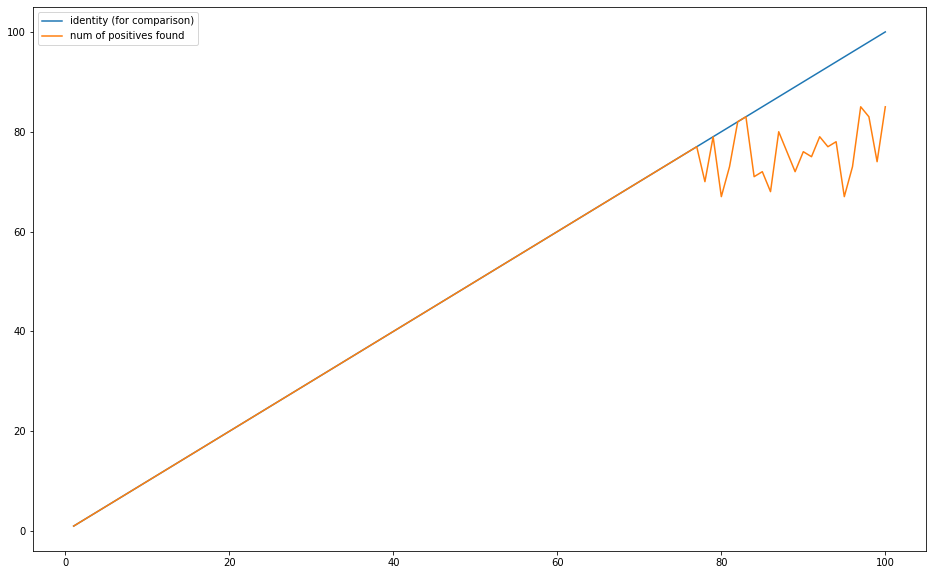

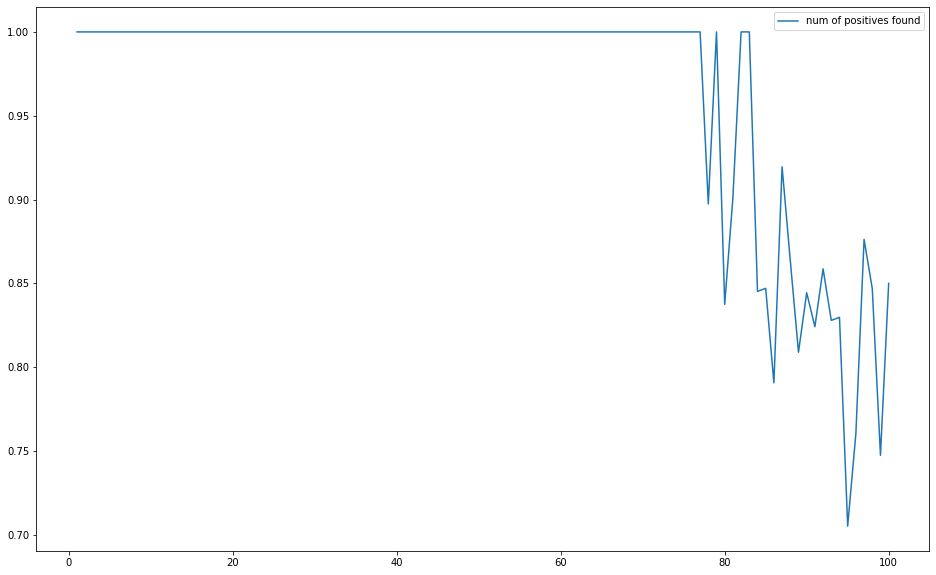

In [48]:
epochs = 10000
max_n, d_sub, d = 100, 50, 100

pgen = PointGenerator(d_sub, d)

_range = range(1, max_n+1)
poses = []
for n in tqdm(_range):
    points = np.stack([pgen.point() for i in range(n)], axis=0)
    _, (pos_count, _, _) = gmaker(points, epochs=epochs, verbose=0)
    poses.append(pos_count)

plotter(list(_range), poses)
plotter(list(_range), np.array(poses)/np.array(_range), iden=0)

#### Fix $d$ and number of points, $d_{sub}$ varries